In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

In [4]:
# Load the uploaded datasets
root_path = os.getcwd()
train_dataset = pd.read_excel(root_path + "/data/Tongji/time_series_375_prerpocess_en.xlsx")
test_dataset = pd.read_excel(root_path + "/data/Tongji/time_series_test_110_preprocess_en.xlsx")

def generate_clean_train_dataset(df, feature_list):
    df["PATIENT_ID"] = df["PATIENT_ID"].ffill()
    df = df.loc[:, feature_list].copy()
    df["Admission time"] = pd.to_datetime(df["Admission time"])
    df["Discharge time"] = pd.to_datetime(df["Discharge time"])
    df["t"] = (df["Discharge time"] - df["Admission time"]).dt.days
    t_list = df.groupby("PATIENT_ID")["t"].unique().apply(lambda x: x[0]).tolist()
    outcome_list = df.groupby("PATIENT_ID")["outcome"].unique().apply(lambda x: x[0]).tolist()
    y_target = [min(35, t) if outcome == 0 else 70 - min(35, t) for outcome, t in zip(outcome_list, t_list)]
    df = df.drop(columns=["outcome"], errors="ignore")
    return df, y_target

test_features_list = test_dataset.columns.tolist()
X_train, y_train = generate_clean_train_dataset(train_dataset, test_features_list)
X_test, y_test = generate_clean_train_dataset(test_dataset, test_features_list)

imputer = KNNImputer(n_neighbors=5)
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_numeric), columns=X_train_numeric.columns)
X_test_numeric = X_test.select_dtypes(include=[np.number])
X_test_imputed = pd.DataFrame(imputer.transform(X_test_numeric), columns=X_test_numeric.columns)

X_train_final = X_train_imputed.groupby("PATIENT_ID").last().reset_index()
X_test_final = X_test_imputed.groupby("PATIENT_ID").last().reset_index()

X_train_tensor = torch.tensor(X_train_final.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_final.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [ ]:
class GRUTeacherModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, attention=True, pretrained_weights=None):
        super(GRUTeacherModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.4)
        self.attention = attention
        self.attention_fc = nn.Linear(hidden_size, 1) if attention else None
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size // 2)

        if pretrained_weights:
            self.load_pretrained_weights(pretrained_weights)

    def load_pretrained_weights(self, weights_path):
        if isinstance(weights_path, dict):
            state_dict = weights_path['net']
        else:
            state_dict = torch.load(weights_path)['net']
        self.gru.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension (batch_size, seq_len=1, input_size)
        gru_out, _ = self.gru(x)  # (batch_size, seq_len, hidden_size)

        if self.attention:
            attn_weights = torch.softmax(self.attention_fc(gru_out), dim=1)  # Attention weights
            x = torch.sum(gru_out * attn_weights, dim=1)  # Weighted sum of GRU outputs
        else:
            x = gru_out[:, -1, :]  # Last hidden state if no attention

        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)
        out = self.fc2(x)
        return out

    
input_size = X_train_final.shape[1] 
hidden_size = 256  
output_size = 1
weights_path = torch.load("E:/DistCare-main/DistCare-main/model/pretrained-challenge-front-fill-teacher-2covid")

model = GRUTeacherModel(input_size, hidden_size, output_size, pretrained_weights=weights_path)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

epochs = 75
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss / len(train_loader)}")

model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item()
print(f"Test Loss (MSE): {test_loss / len(test_loader)}")

with torch.no_grad():
    predictions = model(X_test_tensor).squeeze(1)  
    predictions_np = predictions.numpy()  
    y_test_np = y_test_tensor.numpy()  

    mse = mean_squared_error(y_test_np, predictions_np)
    mae = mean_absolute_error(y_test_np, predictions_np)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

C:\Users\Surya\AppData\Local\Temp\ipykernel_26276\1376887730.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_path = torch.load("E:/DistCare-main/DistCare-main/m

Epoch 1/75, Training Loss: 1892.8565165201824
Epoch 2/75, Training Loss: 1738.19091796875
Epoch 3/75, Training Loss: 1657.3985595703125
Epoch 4/75, Training Loss: 1563.8542175292969
Epoch 5/75, Training Loss: 1508.243901570638
Epoch 6/75, Training Loss: 1407.1670379638672
Epoch 7/75, Training Loss: 1408.9773356119792
Epoch 8/75, Training Loss: 1326.3938903808594
Epoch 9/75, Training Loss: 1274.5380350748699
Epoch 10/75, Training Loss: 1241.2523498535156
Epoch 11/75, Training Loss: 1210.4048461914062
Epoch 12/75, Training Loss: 1151.6995391845703
Epoch 13/75, Training Loss: 1117.2984008789062
Epoch 14/75, Training Loss: 1111.5638224283855
Epoch 15/75, Training Loss: 1104.7498931884766
Epoch 16/75, Training Loss: 1066.511983235677
Epoch 17/75, Training Loss: 1017.0231984456381
Epoch 18/75, Training Loss: 959.1981862386068
Epoch 19/75, Training Loss: 977.3581797281901
Epoch 20/75, Training Loss: 932.9674021402994
Epoch 21/75, Training Loss: 905.2616221110026
Epoch 22/75, Training Loss: 83

In [ ]:
class GRUStudentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(GRUStudentModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size // 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension (batch_size, seq_len=1, input_size)
        gru_out, _ = self.gru(x)  # (batch_size, seq_len, hidden_size)
        x = gru_out[:, -1, :]  # Take last hidden state
        x = F.relu(self.fc1(x))
        x = self.batch_norm(x)
        out = self.fc2(x)
        return out

teacher_model = GRUTeacherModel(input_size, 256, output_size, pretrained_weights=weights_path)  
student_model = GRUStudentModel(input_size, 128, output_size)  

teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

# Training with Knowledge Distillation
epochs = 75
alpha = 0.5  # Weight for hard vs. soft loss
temperature = 2.0  # Temperature for softmax smoothing

criterion = nn.MSELoss()
kl_div_loss = nn.KLDivLoss(reduction="batchmean")
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)

for epoch in range(epochs):
    student_model.train()
    teacher_model.eval()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Teacher predictions (soft targets)
        teacher_outputs = teacher_model(X_batch).detach()
        # Student predictions
        student_outputs = student_model(X_batch)

        # Losses
        hard_loss = criterion(student_outputs, y_batch)
        soft_loss = kl_div_loss(
            F.log_softmax(student_outputs / temperature, dim=1),
            F.softmax(teacher_outputs / temperature, dim=1)
        )
        loss = alpha * hard_loss + (1 - alpha) * soft_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader)}")

# Evaluation
student_model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        predictions = student_model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item()
print(f"Student Test Loss (MSE): {test_loss / len(test_loader)}")

# Metrics
with torch.no_grad():
    predictions = student_model(X_test_tensor).squeeze(1).numpy()
    y_test_np = y_test_tensor.numpy().flatten()

    mse = mean_squared_error(y_test_np, predictions)
    mae = mean_absolute_error(y_test_np, predictions)

print(f"Student Test MSE: {mse:.4f}")
print(f"Student Test MAE: {mae:.4f}")

Epoch [1/75], Loss: 951.5920155843099
Epoch [2/75], Loss: 908.7771504720052
Epoch [3/75], Loss: 875.8622029622396
Epoch [4/75], Loss: 861.6532643636068
Epoch [5/75], Loss: 842.3423156738281
Epoch [6/75], Loss: 821.1114451090494
Epoch [7/75], Loss: 800.885019938151
Epoch [8/75], Loss: 768.1112721761068
Epoch [9/75], Loss: 749.0729370117188
Epoch [10/75], Loss: 727.4374974568685
Epoch [11/75], Loss: 695.2177607218424
Epoch [12/75], Loss: 673.4169692993164
Epoch [13/75], Loss: 643.7560602823893
Epoch [14/75], Loss: 620.8021189371744
Epoch [15/75], Loss: 602.7442169189453
Epoch [16/75], Loss: 583.7998835245768
Epoch [17/75], Loss: 568.5081926981608
Epoch [18/75], Loss: 537.6833292643229
Epoch [19/75], Loss: 521.4496955871582
Epoch [20/75], Loss: 501.2840220133464
Epoch [21/75], Loss: 477.1706237792969
Epoch [22/75], Loss: 462.45310465494794
Epoch [23/75], Loss: 443.79379018147785
Epoch [24/75], Loss: 425.4518229166667
Epoch [25/75], Loss: 411.4547945658366
Epoch [26/75], Loss: 385.41418202

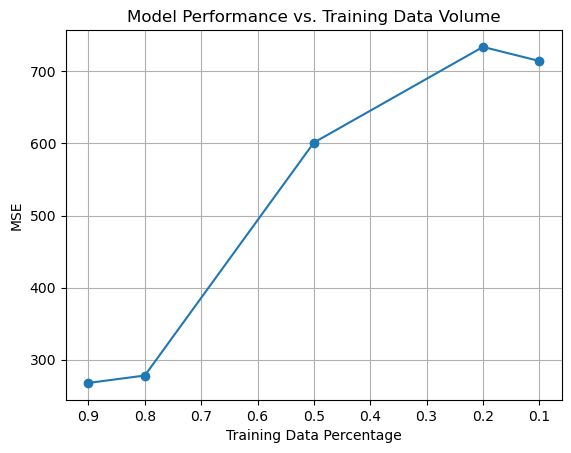

In [ ]:
def evaluate_different_training_volume(X_train, y_train, X_test, y_test):
    epochs = 100  
    batch_size = 32
    pct_list = [0.9, 0.8, 0.5, 0.2, 0.1]  

    y_train_series = pd.Series(y_train, index=X_train.index)
    mse_scores = []

    for pct in pct_list:
        X_train_pct = X_train.sample(frac=pct, replace=False, random_state=42)
        y_train_pct = y_train_series.loc[X_train_pct.index]

        X_train_tensor = torch.tensor(X_train_pct.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_pct.values, dtype=torch.float32).unsqueeze(1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        input_size = X_train_tensor.shape[1]
        student_model = GRUStudentModel(input_size, 64, 1, num_layers=2)  
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)

        for epoch in range(epochs):
            student_model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = student_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        student_model.eval()
        with torch.no_grad():
            predictions = student_model(X_test_tensor).squeeze(1).numpy()
            y_test_np = y_test_tensor.numpy().flatten()
            mse = mean_squared_error(y_test_np, predictions)
        mse_scores.append(mse)

    return pct_list, mse_scores


pct_list, mse_scores = evaluate_different_training_volume(X_train_final, y_train, X_test_final, y_test)

plt.plot(pct_list, mse_scores, marker='o')
plt.gca().invert_xaxis()
plt.xlabel("Training Data Percentage")
plt.ylabel("MSE")
plt.title("Model Performance vs. Training Data Volume")
plt.grid()
plt.show()


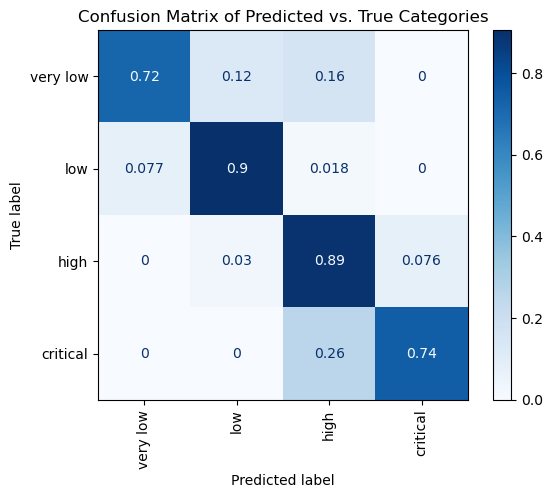

In [ ]:
def categorize(y):
    categories = []
    for value in y:
        if value < 7:
            categories.append("very low")
        elif 7 <= value < 35:
            categories.append("low")
        elif 35 <= value < 63:
            categories.append("high")
        else:  
            categories.append("critical")
    return categories

def plot_confusion_matrix(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze(1).numpy()
        y_true = y_tensor.numpy().flatten()

        pred_categories = categorize(predictions)
        true_categories = categorize(y_true)

        cm = confusion_matrix(true_categories, pred_categories, labels=["very low", "low", "high", "critical"])
        cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["very low", "low", "high", "critical"])
        disp.plot(cmap="Blues", xticks_rotation="vertical")
        plt.title("Confusion Matrix of Predicted vs. True Categories")
        plt.show()

plot_confusion_matrix(student_model, X_train_tensor, y_train_tensor)